# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Project Overview

This project aims to answer the question as to which are the drivers for an effective offer and what can we extract from the data that is provided.

I explore different models and draw conclusions based on the accuracy as to which one comes out on top. We want to answer the following questions:
- What are the main factors of an affective offer 
- Can we categorize whether a user will take up the offer
- Get an idea of the demographics, income etc. of our customers during data exploration

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
# PCA Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from time import time
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


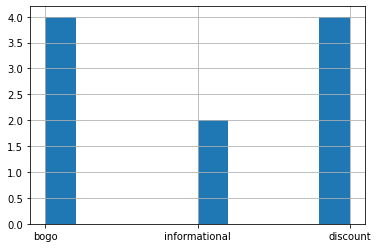

In [3]:
portfolio.offer_type.hist();

In [4]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [5]:
portfolio.id.nunique()

10

In [6]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

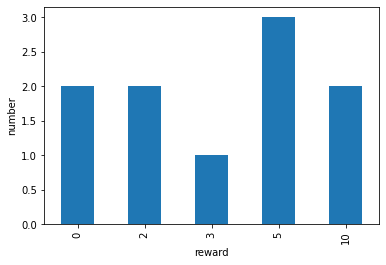

In [7]:
# Offers
portfolio.groupby('reward')['id'].count().plot(kind='bar', xlabel='reward', ylabel='number');

In [8]:
channel_list = set()
for channels in portfolio['channels']:
    channel_list.update(channels)
    
channel_list = list(channel_list)
channel_list

['mobile', 'email', 'web', 'social']

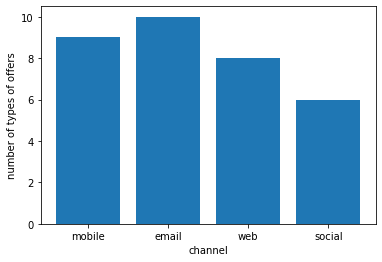

In [9]:
channel_freq = dict.fromkeys(channel_list, 0)
for channel in channel_list:
    for offer in portfolio['channels']:
        if channel in offer:
            channel_freq[channel] = channel_freq[channel] + 1
    
plt.bar(channel_freq.keys(), channel_freq.values())
plt.xlabel('channel')
plt.ylabel('number of types of offers');

We see here that most of the offers were delivered via email and then via the app. This may result in results being skewed towards a certain demographic.

In [10]:
# Categorical columns for bogo, discount and info
portfolio_analysis = portfolio.copy()
for category in ['bogo', 'discount', 'informational']:
    portfolio_analysis[category] = portfolio_analysis['offer_type'].apply(lambda x: 1 if x == category else 0)

portfolio_analysis.head()

,reward,channels,difficulty,duration,offer_type,id,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [11]:
for channel in channel_list:
    portfolio_analysis[channel] = portfolio_analysis['channels'].apply(lambda chan: 1 if channel in chan else 0 )
    
portfolio_analysis.head()

,reward,channels,difficulty,duration,offer_type,id,bogo,discount,informational,mobile,email,web,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,0,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,1,1,0


### Profile Data

In [12]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


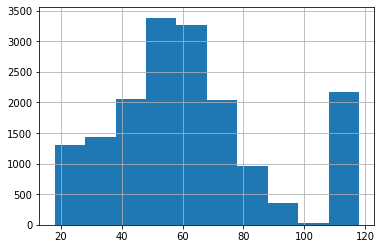

In [13]:
profile.age.hist();

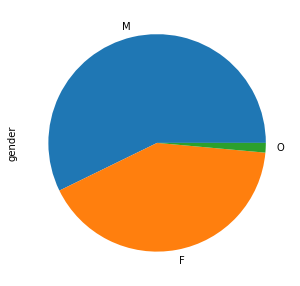

In [14]:
profile.gender.value_counts().plot.pie(figsize=(5,5));

In [15]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [16]:
# Add useful columns for Month, Day and Year
profile['became_member_day'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.day
profile['became_member_month'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.month
profile['became_member_year'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.year

profile.head()

,gender,age,id,became_member_on,income,became_member_day,became_member_month,became_member_year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,12,2,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,15,7,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,12,7,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,9,5,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4,8,2017


In [17]:
profile.isna().sum()

gender                 2175
age                       0
id                        0
became_member_on          0
income                 2175
became_member_day         0
became_member_month       0
became_member_year        0
dtype: int64

### Demographics of users

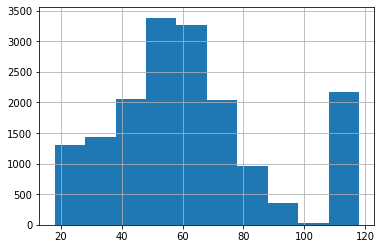

In [18]:
profile.age.hist();

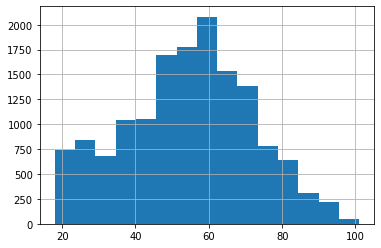

In [19]:
profile_clean = profile.copy()
profile_clean['age'] = profile_clean['age'].apply(lambda x: np.nan if x == 118 else x)
profile_clean['age'].hist(bins=15);
profile = profile_clean

Comments: There is an odd set of entries for age 118 which doesn't make sense. It might be a good idea to ignore the age in this case or remove the entries with this age. 

This might indicate a bug in the app as well. Or a flaw in the signup form.

In [20]:
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

gender                 0
age                    0
id                     0
became_member_on       0
income                 0
became_member_day      0
became_member_month    0
became_member_year     0
dtype: int64


,gender,income,age


In [21]:
profile['id'].nunique()

17000

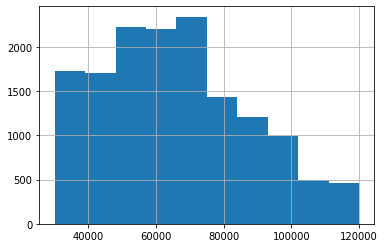

In [22]:
profile.income.hist();

In [23]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

### Transactions
All the transactions are contained in `transcript.json` as well as events etc.

In [24]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


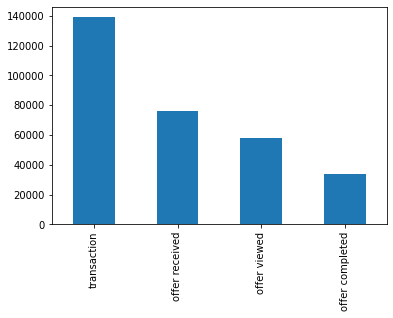

In [25]:
transcript.event.value_counts().plot.bar();

In [26]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [27]:
transcript['person'].nunique()

17000

In [28]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [29]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [30]:
# Create an offer_id column that resolves all the other columns
transcript['offer_id_new'] = np.where(transcript['offer id'].isnull() & 
                                      transcript['offer_id'].notnull(),
                                      transcript['offer_id'],
                                      transcript['offer id'])

transcript.drop(['offer id','offer_id'], axis=1, inplace=True)
transcript.rename(columns={'offer_id_new': 'offer_id'}, inplace=True)

In [31]:
transcript.head()

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


### Income Stats

Below we'll try to see how many females and males have become members. And their income levels.

In [32]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [33]:
def init_agerange(profile,
                  gender_integer_map):
    """ Initializes a DataFrame that describes a customer's age range as 
    a function of gender
    
    INPUT:
        profile: DataFrame that stores customer profiles
        gender_integer_map: Dictionary that describes the mapping of a
                            gender string to an integer
    OUTPUT:
        age_range: DataFrame that describes a customer's age range as a
                   function of gender
    """
    pattern_obj = re.compile('^\[[0-9]+, [0-9]+\)')

    is_ohe_column =\
        [pattern_obj.match(str(elem)) != None for elem in profile.columns]

    age_range = profile[['gender']].copy()
    age_range['gender'] = genderint_to_string(age_range,
                                            gender_integer_map)

    age_range['agerange'] =\
        profile.apply(lambda elem: reverse_ohe(elem, is_ohe_column), axis=1)

    age_range = age_range.groupby(['agerange', 'gender']).size()

    age_range = age_range.reset_index()

    age_range.columns = ['agerange', 'gender', 'count']

    is_above_100 = re.compile('\[10[0-9]+.*')
    h_transform = lambda elem: is_above_100.match(elem) != None
    above_100 = age_range['agerange'].apply(h_transform)

    return pd.concat([age_range[above_100 == False], age_range[above_100]])


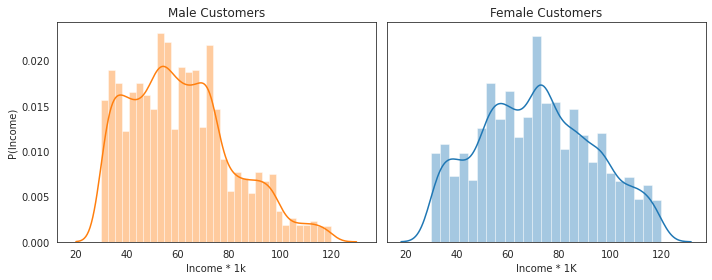

In [34]:
male_customers = profile[profile['gender'] == 'M']
female_customers = profile[profile['gender'] == 'F']
current_palette = sns.color_palette()
#sns.set(font_scale=1.5)
sns.set_style('white')
fix, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)
plt.sca(ax[0])
sns.distplot(male_customers['income']/1000,  # for kilo
             color=current_palette[1])
plt.xlabel('Income * 1k')
plt.ylabel('P(Income)')
plt.title('Male Customers')
plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income * 1K')
plt.ylabel('P(Income)')
plt.title('Female Customers')
plt.tight_layout()

Text(0, 0.5, 'Count')

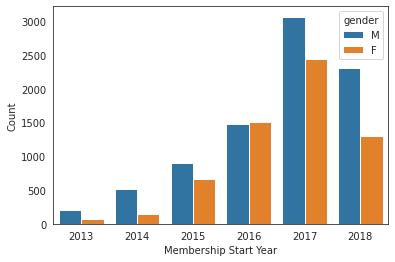

In [35]:
# tips = sns.load_dataset("tips")
# tips.head()
xx = male_customers.became_member_year.value_counts().sort_index().index
yy = male_customers.became_member_year.value_counts().sort_index()
d = {
    'year': xx,
    'count': yy,
    'gender': 'M'
}

year_count = pd.DataFrame(d)

xx = female_customers.became_member_year.value_counts().sort_index().index
yy = female_customers.became_member_year.value_counts().sort_index()
d = {
    'year': xx,
    'count': yy,
    'gender': 'F'
}
# year_count = year_count.merge(year_count, left_on='year')
pp = year_count.append(pd.DataFrame(d)).reset_index()
sns.barplot(x=pp['index'],
            y=pp['count'], hue='gender', data=pp);
plt.xlabel('Membership Start Year')
plt.ylabel('Count')


- On average, the income level of females is higher than males.
- 2017 and 2018 saw the biggest growth in memberships


## Preprocessing Data

In [36]:
extended_profile = profile.copy()

# create categorical variables
extended_profile['M'] = profile['gender'].apply(lambda g: 1 if g == 'M' else 0)
extended_profile['F'] = profile['gender'].apply(lambda g: 1 if g == 'F' else 0)
extended_profile['O'] = profile['gender'].apply(lambda g: 1 if g == 'O' else 0)

later I discovered the pandas.get_dummies() function (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) which I also use below

In [37]:
profile.head()

,gender,age,id,became_member_on,income,became_member_day,became_member_month,became_member_year
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,12,2,2017
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,15,7,2017
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,12,7,2018
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,9,5,2017
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4,8,2017


In [38]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

# join transcript with offers
transcript = transcript.merge(portfolio, how='left', on='offer_id')

In [39]:
transcript.groupby(['event', 'offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

### Preprocessing datasets

In [40]:
# define drop_cols lambda
drop_cols = lambda col, df, inplace=False: df.drop(columns=col, axis=1, inplace=inplace)

In [41]:
# clean dataset
transcript = drop_cols(['reward_x', 'reward_y'], transcript)

transcript=transcript.sort_values(['person','time'])

In [42]:
transcript.head()

,person,event,value,time,amount,offer_id,channels,difficulty,duration,offer_type
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational


In [43]:
transcript[['offer_id', 'person']].describe()

,offer_id,person
count,167581,306534
unique,10,17000
top,fafdcd668e3743c1bb461111dcafc2a4,94de646f7b6041228ca7dec82adb97d2
freq,20241,51


In [44]:
# offers viewed and transacted
offers_view_transacted = transcript[['time','offer_id','person','event']][(transcript['event'] == 
                                                                           'transaction') | 
                                                                          (transcript['event'] ==
                                                                           'offer viewed')]
offers_view_transacted['offer_id'] = offers_view_transacted['offer_id'].ffill()
offers_view_transacted.head()

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed


In [45]:
transcript = transcript.merge(offers_view_transacted, how='left', on=['person','time','event'])

In [46]:
# clean up dataset to unify multiple offer_id columns into one column
transcript['offer_id'] = np.where(transcript['offer_id_x'].isnull(),
                                  transcript['offer_id_y'],
                                  transcript['offer_id_x'])

drop_cols(['offer_id_x', 'offer_id_y'], transcript, inplace=True)

In [47]:
# merge portfolio dataset again to get offer data for the transaction events
transcript = transcript.merge(portfolio, how='left', on='offer_id')
transcript['duration'] = np.where(transcript['duration_x'].isnull(),
                                  transcript['duration_y'],
                                  transcript['duration_x'])
drop_cols(['duration_x', 'offer_type_x', 'difficulty_x', 'channels_x', 'duration_y'],
          transcript,
          inplace=True)
transcript.rename(columns={'channels_y': 'channels', 
                           'reward_y': 'reward', 
                           'difficulty_y': 'difficulty', 
                           'offer_type_y': 'offer_type'},
                  inplace=True)

In [48]:
transcript.head()

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0


### Offers completed after viewing

In [49]:
# get offer viewed, transactions and offer completed
offers_viewed_transactions_completed = transcript[(transcript['event'] == 'offer viewed') | 
                                                  (transcript['event']=='transaction') | 
                                                  (transcript['event']=='offer completed')].copy()

In [50]:
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(
    ['person','offer_id'])['offer_id'].shift()

In [51]:
offers_viewed_transactions_completed['valid_completed'] = np.where(
    offers_viewed_transactions_completed['offer_id_previous'] ==
    offers_viewed_transactions_completed['offer_id'], 1, 0)

In [52]:
# get only offer received events
offers_received = transcript[transcript['event'] == 'offer received'].copy()

# ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous'] = np.nan
offers_received['valid_completed'] = np.nan

# append datasets to complete dataset of transactions
transcript=offers_received.append(offers_viewed_transactions_completed)

# sort values
transcript=transcript.sort_values(['person','time'])

In [53]:
split = lambda offer_type, df: df[df['offer_type'] == offer_type].copy()

#split transcript into 3 different offer types
transcript_bogo = split('bogo', transcript)
transcript_discount = split('discount', transcript)
transcript_info = split('informational', transcript)

**Explanation**

Here we've taken the `transcript` dataframe and split it into 3 types of offers. This will be very useful later when we want to analyze the three offers seperately.

### PCA and K-means
Below, we perform PCA analysis and StandardScaler preprocessing. Then we compare it to a K-means analysis

In [54]:
sc = StandardScaler(with_mean=True, with_std=True, copy=True)
pca = PCA(copy=True, random_state=42)

In [55]:

def clustered_bar_plot(data, group_labels, series_labels, n_series):
    '''
    Clustered bar plot.
    Inputs:
    data: square 2-d array of data. rows are components, columns are variables
    group_labels: labels for main groups along x-axis. all groups are plotted.
    series_labels: labels for sugroups within groups
    n_series: number of series (subgroups) to plot. the first n_series are plotted.
    Return: none
    '''
    n_groups = data.shape[1]
    if n_series > data.shape[0]:
        print('The maximum number of series ({}) in the data will be plotted, though request is for {} series.'
              .format(data.shape[0], n_series))
        n_series = data.shape[0]
    width = 0.7 / n_series # width of bar for each series
    x0 = -(n_series - 1) / 2 # offset of first series's bar from tick at the center of the group
    x = np.arange(n_groups)
    
    plt.figure(figsize=(15,5))
    for i in range(n_series):
        plt.bar(x + x0 * width, data[i], width=width, label=series_labels[i])
        x0 += 1
    plt.xticks(x, group_labels)
    plt.legend()
    plt.axhline(linewidth=1, color='black');

In [56]:
features = ['age', 'income', 'M', 'F', 'O', 'became_member_year']
n_features = len(features)
X = extended_profile[features].dropna()  # remove NAN for pca.fit()
X_scaled = sc.fit_transform(X)

pca.fit(X_scaled)

PCA(random_state=42)

In [57]:
pca.singular_values_

array([1.78396683e+02, 1.30448476e+02, 1.23372783e+02, 1.21255738e+02,
       1.00915911e+02, 5.00436738e-14])

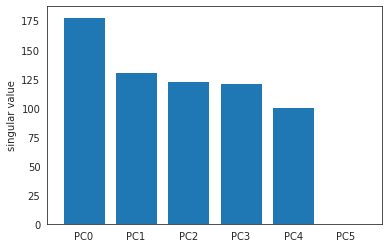

In [58]:
def plot_sv(sv):
    '''
    barchart showing the singular values
    Input:
        sv (array) singular values
    Returns: none
    '''
    xticklabels = []
    for i in range(len(sv)):
        xticklabels.append('PC' + str(i))
        
    plt.bar(xticklabels, sv)
    plt.ylabel('singular value');
    
    return

plot_sv(pca.singular_values_)

PC0 is significant and PC1-4 also account for the variance in data. PC5 is negligible

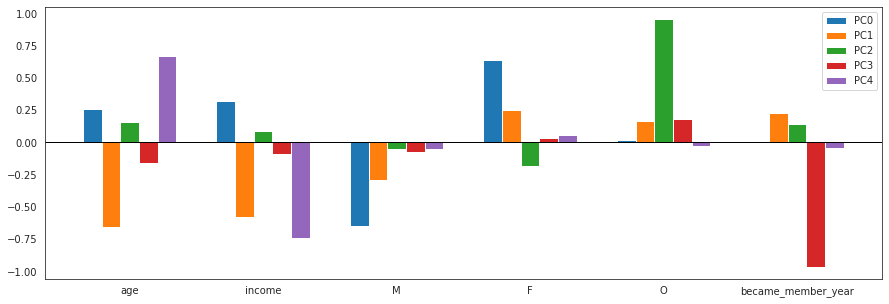

In [59]:
clustered_bar_plot(pca.components_, features, 
                   ['PC' + str(i) for i in range(pca.components_.shape[1])], 
                   pca.components_.shape[1]-1)

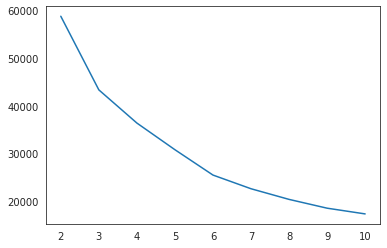

In [60]:

km_results = []
km_fit = []

for n_clusters in range(2,11):
    km = KMeans(n_clusters=n_clusters, random_state=42) #99
    km.fit(X_scaled)
    km_fit.append(km)
    km_transform = km.transform(X_scaled)
    inertia = km.inertia_
    km_results.append([n_clusters, inertia, km.cluster_centers_])

km_results = pd.DataFrame(km_results)
plt.plot(km_results[0], km_results[1]);

As clusters are increased, k-mean performance improves

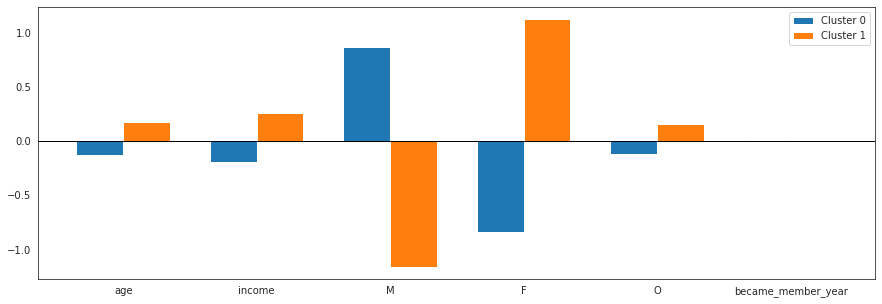

In [61]:
clustered_bar_plot(km_results.iloc[0][2], features, 
                   ['Cluster ' + str(i) for i in range(km_results.iloc[0][2].shape[0])], 
                   km_results.iloc[0][2].shape[0])

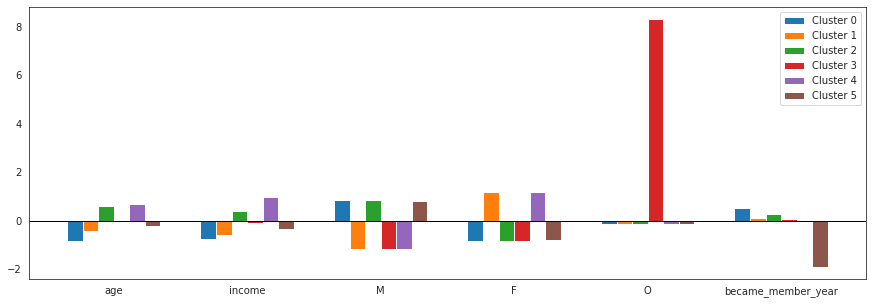

In [62]:
clustered_bar_plot(km_results.iloc[4][2], features, 
                         ['Cluster ' + str(i) for i in range(km_results.iloc[4][2].shape[0])], 
                         km_results.iloc[4][2].shape[0])

**Analysis:**

    - Male have below average income. 
    - Females are above average in age and income
    - PC0 for male and female are opposite (as expected)
    - PC1 for age and income seem to indicate that income increases with age generally.

## Types of Customers
As defined in the problem statement, we can divide the target audience into different types...

Type-1: Members who got the offer, viewed the offer and did a transaction

Type-2: Members who viewed the offer

Type-3: Member got the offer, did a transaction, completed and viewed the offer i.e. offer was completed regardless of advertisement

Type-4: Offer received by member


We will attempt to study the different types of customers and see what the drivers for a conversion are.

Information model is the hardest to evaluate, so we will start with bogo and discount offers first. 

In [63]:
# A type-1 person has completed the offer i.e. has the 'offer completed' event
type1 = lambda df: df[['person','offer_id']][(df['valid_completed'] == 1) & 
                             (df['event'] == 'offer completed')].groupby(['person','offer_id']).count().reset_index()

type1_bogo = type1(transcript_bogo)
type1_discount = type1(transcript_discount)

**Note on information offers*: The validity has to be also taken into consideration. It is done later.

In [64]:
def num_conversions(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people who converted 
    vs people with just offer received events. 
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person to offer_id pairs 
    with conversion events and offers received events
    '''
    
    # offer ids that have transactions or conversions
    conversion_ids = df[['person', 'offer_id']]\
                        [(df['event'] == 'transaction') | (df['event'] == 'offer completed') ]\
                        .groupby(['person', 'offer_id']).count().reset_index()

    only_offers = df[['person', 'offer_id']]\
                      [df['event'] == 'offer received']\
                      .groupby(['person', 'offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge = conversion_ids.merge(only_offers,
                                       how='right',
                                       on=['person', 'offer_id'],
                                       indicator=True)
    return check_merge


check_merge_bogo = num_conversions(transcript_bogo)
print('BOGO Offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount = num_conversions(transcript_discount)
print('Discount Offers:')
print(check_merge_discount.groupby(['_merge']).count())

BOGO Offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
Discount Offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


`right_only` are conversion events

`left_only` are only offer received events


In [65]:
# define Type-2 and 4
def type_2_4(df):
    
    '''
    Takes in output dataframe from num_conversions() to split into type 2 and 4 customers.
    
    inputs:
    - df: output dataframe from num_conversions()
    
    outputs:
    - Returns 2 dataframes for type-2 and type-4 customers 
    '''
    
    # Type 2 and 4 customers have both received the offer
    subset_2_4 = df[df['_merge'] == 'right_only']

    # Transactions are part of the transcript dataframe
    subset_2_4 = subset_2_4.merge(transcript,
                            how='left',
                            on=['person', 'offer_id'])

    # Type-2 people have only viewed the offer
    type2 = subset_2_4[['person', 'offer_id']][subset_2_4['event'] == 'offer viewed']\
                    .groupby(['person', 'offer_id']).count().reset_index()
    
    # The remaining people belong to type-4 in subset_2_4
    drop_cols('_merge', subset_2_4, inplace=True)
    type4 = subset_2_4.merge(type2[['person', 'offer_id']],
                         how='left',
                         indicator=True)
    type4 = type4[type4['_merge'] == 'left_only'].copy()
    
    return type2, type4

type2_bogo, type4_bogo = type_2_4(check_merge_bogo)
type2_discount, type4_discount = type_2_4(check_merge_discount)

In [66]:
# Type-3: people who did the transaction regardless of the offer
def type3(df):
    '''
    Type-3 people
    
    inputs:
    - df: transcript dataframe of bogo or discount
    
    outputs:
    - dataframe of people who completed offer       
    '''
    
    #check all conversion events with invalid conversions
    type3 = df[['person','offer_id']][(df['event'] == 'offer completed') & 
                                     (df['valid_completed']!=1)]\
                                    .groupby(['person', 'offer_id']).count().reset_index()
    return type3

type3_bogo = type3(transcript_bogo)
type3_discount = type3(transcript_discount)

In [67]:
def offers(type1, type2):
    '''
    inputs:
    - type1: dataframe containing Type-1 customer data 
    - type2: dataframe containing Type-2 customer data
    
    outputs:
    - Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    type1['effective_offer'] = 1
    type2['effective_offer'] = 0

    #append datasets together
    offers = type1.append(type2, sort=False)
    return offers

offers_bogo = offers(type1_bogo, type2_bogo)
offers_discount = offers(type1_discount, type2_discount)

#### Informational offers

Informational offers need to also consider the duration for which they're valid. The time in `transcript` is in hours which needs to be converted into days. 

In [68]:
#convert time into days
transcript_info['offer_days'] = transcript_info['time']/24
#drop unnecessary columns
drop_cols(['time', 'value', 'offer_id_previous'], transcript_info, inplace=True)

In [69]:
transcript_info = transcript_info.sort_values(['person', 'offer_days', 'event', 'offer_id'])

In [70]:
transcript_info['diff_info'] = transcript_info[
    (transcript_info['offer_type'] == 'informational') & 
    ((transcript_info['event'] == 'offer received') | 
     (transcript_info['event']=='transaction'))].groupby(['person','offer_id'])['offer_days'].diff()

In [71]:
#create column for flagging valid events
transcript_info['valid_completed_duration'] = 0

#flag valid events if within duration
transcript_info.loc[transcript_info['diff_info'] <= 
                    transcript_info['duration'],
                    'valid_completed_duration'] = 1


In [72]:
#flag effective_offers where valid_completed=1 and valid_completed_duration=1
transcript_info['effective_offer'] = np.where(((transcript_info['valid_completed'] == 1) & 
                                               (transcript_info['valid_completed_duration'] == 1)),
                                              1, 0)

In [73]:
# separate Type-1 info
type1_info = transcript_info[['person', 'offer_id']][transcript_info['effective_offer'] == 1].groupby(
    ['person','offer_id']).sum().reset_index()

In [74]:
#separate out type 2 of customers
check_merge_info = num_conversions(transcript_info)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [75]:
type2_info, type4_info = type_2_4(check_merge_info)

In [76]:
# scenario 1
type3_1 = transcript_info[['person','offer_id']][(transcript_info['event'] == 'transaction') &
                                                (transcript_info['valid_completed']!=1) & 
                                                (transcript_info['valid_completed_duration'] == 1)].groupby(['person','offer_id']).count().reset_index()
# scenario 2
type3_2 = transcript_info[['person','offer_id']][(transcript_info['event'] == 'transaction') &
                                                (transcript_info['valid_completed']==1) & 
                                                (transcript_info['valid_completed_duration'] != 1)].groupby(['person','offer_id']).count().reset_index()
type3_info = type3_1.append(type3_2, sort=False)

In [77]:
offers_info = offers(type1_info, type2_info)

### Features

In [78]:
#rename column for merging
profile.rename(columns={'id':'person'}, inplace=True)

#create function to reuse for 3 datasets
def membership_tenure(df):
    '''
    Get a rough duration of membership
    
    inputs:
    - df: original dataframe to transform membership_tenure_days column  
    
    outputs:
    - Returns dataframe with membership_tenure_days column transformed to be tenure in days
    '''
    #merge to get user demographic profile
    df = df.merge(profile, how='left', on='person')

    latest_year = df['became_member_year'].max()
    df['membership_tenure_days'] = ((latest_year - df['became_member_year']) * 365) +\
                                    (30 * df['became_member_month']) +\
                                    df['became_member_day']
    return df

offers_bogo = membership_tenure(offers_bogo)
offers_discount = membership_tenure(offers_discount)
offers_info = membership_tenure(offers_info)

In [79]:
offers_bogo.became_member_year.min()

2013

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


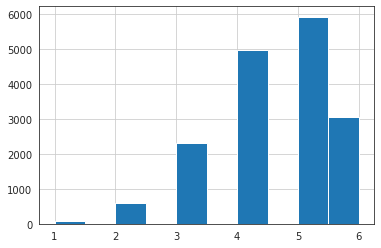

In [80]:
#group event=offer received per person in transactional records
print(transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count().hist();

In [81]:
# count of offers received per person
df_offer_received_cnt = transcript[transcript['event'] == 'offer received'].groupby(
    ['person','offer_id','time']).count()['event'].reset_index()


df_offer_received_cnt.rename(columns={'event': 'offer_received_cnt'}, inplace=True)

# drop unnecessary columns
drop_cols('time', df_offer_received_cnt, inplace=True)

# ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person', 'offer_id']).sum().reset_index()

### Behavior-transaction Grouping

In [82]:
#filter dataset by invalid transactions
df_transactions_invalid = transcript[(transcript['event'] == 'transaction') & 
                                   (transcript['valid_completed'] == 0)].groupby(
    ['person','offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns={'amount': 'amount_invalid'}, inplace=True)

In [83]:
# Time between offers

# convert time into days
transcript['offer_days'] = transcript['time']/24

# drop the time column because now we'll use the offer_days column 
drop_cols(['time'], transcript, inplace=True);

#find time elapsed between offers received
transcript['time_since_offer'] = transcript[transcript['event'] == 'offer received'].groupby(
    ['person','offer_id'])['offer_days'].diff()

#fill missing values with 0, as if someone does not receive an offer or is receiving an offer for the first time, there is no time elapsed
transcript['time_since_offer'] = transcript['time_since_offer'].fillna(value=0)

#create temporary dataset
df_time_elapsed=transcript.groupby(['person', 'offer_id'])['time_since_offer'].sum().reset_index()

In [84]:
transcript.head()

,person,event,value,amount,offer_id,reward,channels,difficulty,offer_type,duration,offer_id_previous,valid_completed,offer_days,time_since_offer
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,NaN,7.0,0.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,0.0,8.0,0.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0,9.5,0.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,NaN,14.0,0.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,0.0,15.5,0.0


### Data Preperation

In [85]:
# merge to get offers received count and invalid amount transacted 
offers_bogo = offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],
                                how='left',
                                on=['person','offer_id'])
offers_bogo = offers_bogo.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],
                                how='left',
                                on=['person','offer_id'])

In [86]:
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid        96.323752
income                 7.057489
age                    7.057489
gender                 7.057489
offer_received_cnt     0.000000
dtype: float64

An invalid amount can be zeroed for analysis as it will be a conservative figure

In [87]:
# fill missing values for amount_invalid with 0
offers_bogo['amount_invalid'] = offers_bogo['amount_invalid'].fillna(value=0)

# drop null rows (income and gender are affected)
offers_bogo.dropna(inplace=True)

#### Categorical variables

In [88]:
# Rename columns
def rename_col(col_name, df):
    df[col_name] = np.where(df[col_name] == col_name, 1, 0)
    return df


def create_cat_columns(df, col):
    '''
    Create categorical column
    df: Dataframe to use
    col: column name
    '''
    df = pd.concat([df[:], pd.get_dummies(df[col], prefix=col)], axis=1)
    df = drop_cols(col, df)
    return df

In [89]:
# portfolio contains the details of the offers. Merge with bogo offers
offers_bogo = offers_bogo.merge(portfolio, how='left', on='offer_id')

#c onvert channels into categorical variables
channels = offers_bogo['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web', 1:'email', 2:'mobile', 3:'social'})
offers_bogo = pd.concat([offers_bogo[:], channels[:]], axis=1)
rename_col('web', offers_bogo)
rename_col('email', offers_bogo)
rename_col('mobile', offers_bogo)
rename_col('social', offers_bogo)
offers_bogo=drop_cols('channels', offers_bogo)

#convert gender into categorical variables
offers_bogo = create_cat_columns(offers_bogo,'gender')

In [90]:
offers_bogo.head()

,person,offer_id,effective_offer,age,became_member_on,income,became_member_day,became_member_month,became_member_year,membership_tenure_days,...,difficulty,duration,offer_type,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40.0,20180109,57000.0,9,1,2018,39,...,5,7,bogo,1,1,1,0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59.0,20160304,90000.0,4,3,2016,824,...,10,5,bogo,1,1,1,1,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24.0,20161111,60000.0,11,11,2016,1071,...,5,7,bogo,1,1,1,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24.0,20161111,60000.0,11,11,2016,1071,...,5,5,bogo,1,1,1,1,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55.0,20180508,74000.0,8,5,2018,158,...,5,5,bogo,1,1,1,1,1,0,0


In [91]:
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df = df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],
                how='left',
                on=['person','offer_id'])
    df = df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],
                how='left',
                on=['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid'] = df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #merge with portfolio to get offer details
    df = df.merge(portfolio,
                how='left',
                on='offer_id')

    #convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0: 'web',
                                        1: 'email',
                                        2: 'mobile',
                                        3: 'social'})
    df = pd.concat([df[:], channels[:]], axis=1)
    rename_col('web', df)
    rename_col('email', df)
    rename_col('mobile', df)
    rename_col('social', df)
    df = drop_cols('channels', df)
    
    #convert gender column into dummy variables
    df = create_cat_columns(df, 'gender')

    return df

In [92]:
offers_discount = prep_offers_df(offers_discount)

In [93]:
# get offer details from portfolio
offers_info = offers_info.merge(portfolio, how='left', on='offer_id')
offers_info = drop_cols('index', offers_info.reset_index())

# expand channel column into categorical variables
def channel_col(name, df=offers_info):
    '''
    inputs:
    - name: name of channel column to be transformed 
    - df: dataframe 
    
    outputs:
    - offer_info dataframe with channel column transformed
    
    '''
    df[name] = 0
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name] = 1

    return df

In [94]:
channel_list = set()
for channels in portfolio['channels']:
    channel_list.update(channels)

for channel in channel_list:
    channel_col(channel)

drop_cols('channels', offers_info, inplace=True)

In [95]:
def prep_offers_df(df):
    '''
    Impute missing values

    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    df = df.merge(df_offer_received_cnt[['person', 'offer_id', 'offer_received_cnt']], how='left', on=['person', 'offer_id'])
    df = df.merge(df_transactions_invalid[['person', 'offer_id', 'amount_invalid']], how='left', on=['person', 'offer_id'])

    # fill missing values with 0
    df['amount_invalid'] = df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df = create_cat_columns(df, 'gender')
    return df

In [96]:
offers_info = prep_offers_df(offers_info)

In [97]:
offers_info.head()

,person,offer_id,effective_offer,age,became_member_on,income,became_member_day,became_member_month,became_member_year,membership_tenure_days,...,offer_type,mobile,email,web,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33.0,20170421,72000.0,21,4,2017,506,...,informational,1,1,1,0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33.0,20170421,72000.0,21,4,2017,506,...,informational,1,1,0,1,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59.0,20160304,90000.0,4,3,2016,824,...,informational,1,1,0,1,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24.0,20161111,60000.0,11,11,2016,1071,...,informational,1,1,0,1,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26.0,20170621,73000.0,21,6,2017,566,...,informational,1,1,1,0,1.0,0.00,1,0,0


#### Duplicates

check for the possibility of a person having recieved multiple offers


In [98]:
# see if a person has multiple offers
for offers in [offers_bogo, offers_discount, offers_info]:
    print((offers.groupby(['person', 'offer_id', 'effective_offer']).size() > 1).sum())


0
0
0


so each person has a unique active offer. Which simplifies our work

In [99]:
offers_bogo.groupby(['person', 'offer_id', 'effective_offer']).size().head(10)

person                            offer_id                          effective_offer
0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9  1                  1
0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0  1                  1
0020ccbbb6d84e358d3414a3ff76cffd  9b98b8c7a33c4b65b9aebfe6a799e6d9  1                  1
                                  f19421c1d4aa40978ebb69ca19b0e20d  1                  1
004b041fbfe44859945daa2c7f79ee64  f19421c1d4aa40978ebb69ca19b0e20d  1                  1
004c5799adbf42868b9cff0396190900  f19421c1d4aa40978ebb69ca19b0e20d  1                  1
0056df74b63b4298809f0b375a304cf4  9b98b8c7a33c4b65b9aebfe6a799e6d9  1                  1
0082fd87c18f45f2be70dbcbb0fb8aad  9b98b8c7a33c4b65b9aebfe6a799e6d9  1                  1
00857b24b13f4fe0ad17b605f00357f5  f19421c1d4aa40978ebb69ca19b0e20d  0                  1
008d7088107b468893889da0ede0df5c  4d5c57ea9a6940dd891ad53e9dbe8da0  0                  1
dtype: int64

We do not see multiple offers per person

## Model Implementation

In [100]:
#check for class balance in datasets
for offer in [(offers_bogo, "BOGO"), (offers_discount, "Discount"), (offers_info, "Info")]:
    print("\n", offer[1])
    print(offer[0][['person', 'effective_offer']].groupby('effective_offer').count()/len(offer[0]), "\n\n")



 BOGO
                  person
effective_offer         
0                0.17783
1                0.82217 



 Discount
                   person
effective_offer          
0                0.135256
1                0.864744 



 Info
                 person
effective_offer        
0                0.2611
1                0.7389 




We see that for BOGO, 82% offers were successful, discount offers were 86% and info 74% 

In [101]:
# return features and target i.e. effective_offer
data_prep = lambda df, cols_to_drop: (drop_cols(cols_to_drop, df), df['effective_offer'])

In [102]:
# simple model pipeline
def model_pipeline(features, target):
    '''
    inputs:
    - features df
    - target df
    
    outputs:
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)

    # Fit trainingset
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    # transform
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [103]:
def train_predict(clf, train_test_set): 
    '''
    inputs:
    - clf: the classifier
    - sample_size: the size of samples (number) to be drawn from training set
    - train_test_set: training and testing set
    '''
    results = {}
    
    X_train = train_test_set[0]
    X_test = train_test_set[1]
    y_train = train_test_set[2]
    y_test = train_test_set[3]
    
    # Fit training data
    start = time() 
    learner = clf.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end - start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    results['pred_time'] = end - start
    
    #add training accuracy to results
    results['training_score'] = learner.score(X_train, y_train)
    
    #add testing accuracy to results
    results['testing_score'] = learner.score(X_test, y_test)
     
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.3f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.3f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.3f" % results['training_score'])
    print("Test accuracy:%.3f" % results['testing_score'])
    print(classification_report(y_test, predictions_test, digits=3))
    return results

In [104]:
def compare_clf(clf1, clf2, name):
    '''
    inputs:
    - clf1, clf2 classifier models
    - name: name appended to model 
    
    outputs:
    - Results from model prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' + name
        results[clf_name] = {}
        results[clf_name] = train_predict(clf, train_test_set)
    return pd.DataFrame(results)

In [105]:
drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(offers_bogo, drop_cols_prep)
train_test_set = model_pipeline(features, target)

In [106]:
# Use DecisionTreeClassifier as baseline
# https://www.datacamp.com/community/tutorials/decision-tree-classification-python
baseline = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  random_state=42,
                                  min_samples_split=90,
                                  min_samples_leaf=50)

In [107]:
# https://www.datacamp.com/community/tutorials/random-forests-classifier-python
bogo_1 = RandomForestClassifier(random_state=42,
                                max_depth=2, 
                                max_features='auto',
                                min_samples_split=10,
                                n_estimators=5,
                                min_samples_leaf=10)

results = compare_clf(baseline, bogo_1, 'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.174
MSE_test: 0.171
Training accuracy:0.826
Test accuracy:0.829
              precision    recall  f1-score   support

           0      0.552     0.208     0.302       438
           1      0.849     0.963     0.902      2020

    accuracy                          0.829      2458
   macro avg      0.700     0.586     0.602      2458
weighted avg      0.796     0.829     0.795      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.178
MSE_test: 0.178
Training accuracy:0.822
Test accuracy:0.822
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       438
           1      0.822     1.000     0.902      2020

    accuracy                          0.822      2458
   macro avg      0.411     0.500     0.451      2458
weighted avg      0.675     0.822     0.741      2458



In [108]:
drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(offers_discount, drop_cols_prep)
train_test_set = model_pipeline(features, target)

#Initialize the model with hand-coded values
discount_1 = RandomForestClassifier(max_depth= 5, 
                                    max_features='auto',
                                    min_samples_split=2,
                                    n_estimators=10,
                                    min_samples_leaf=2)
results = pd.concat([results[:], compare_clf(baseline, discount_1, 'discount_1')], axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.137
MSE_test: 0.128
Training accuracy:0.863
Test accuracy:0.872
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       325
           1      0.872     1.000     0.932      2220

    accuracy                          0.872      2545
   macro avg      0.436     0.500     0.466      2545
weighted avg      0.761     0.872     0.813      2545

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.137
MSE_test: 0.128
Training accuracy:0.863
Test accuracy:0.872
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       325
           1      0.872     1.000     0.932      2220

    accuracy                          0.872      2545
   macro avg      0.436     0.500     0.466      2545
weighted avg      0.761     0.872     0.813      2545



In [109]:
# Informational offers

features, target = data_prep(offers_info, drop_cols_prep)
train_test_set = model_pipeline(features, target)

# Initialize the model
info_1 = RandomForestClassifier(random_state=42,
                                criterion='gini',
                                max_depth= 5, 
                                max_features= 'auto',
                                min_samples_split=5,
                                n_estimators=5,
                                min_samples_leaf=5)

results = pd.concat([results[:], compare_clf(baseline, info_1, 'info_1')], axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.247
MSE_test: 0.256
Training accuracy:0.753
Test accuracy:0.744
              precision    recall  f1-score   support

           0      0.491     0.161     0.242       355
           1      0.767     0.943     0.846      1042

    accuracy                          0.744      1397
   macro avg      0.629     0.552     0.544      1397
weighted avg      0.697     0.744     0.693      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.247
MSE_test: 0.246
Training accuracy:0.753
Test accuracy:0.754
              precision    recall  f1-score   support

           0      0.634     0.073     0.131       355
           1      0.757     0.986     0.857      1042

    accuracy                          0.754      1397
   macro avg      0.696     0.529     0.494      1397
weighted avg      0.726     0.754     0.672      1397



Accuracy of around 75% is very low

### Model Refinement

In [110]:
#rtr = results.transpose()

#rtr[rtr['testing_score'] == rtr[rtr.index.str.contains("_bogo")]['testing_score'].max()]

In [111]:
# Print best model results for each offer type
def evaluate_performance(offer_type, df_result):
    '''
    input:
    - offer_type: string of offer type name
    - df_result: result dataframe containing testscores
    output:
    - dataframe containing results of best model so far
    '''
    print("\nRandomForest")
    print('For ' + offer_type + ':')
    rtr = df_result.transpose()
    return rtr[rtr['testing_score'] == rtr[rtr.index.str.contains("_"+offer_type)]['testing_score'].max()]


In [112]:
# Discover Optimal Parameters using GridSearch

#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X, y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid = {
                'max_features': ['auto', 'sqrt'],
                'max_depth': [5, 10, 15, 20],
                'n_estimators': [10, 20, 25, 30, 40, 50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [113]:
#define BOGO dataset
features,target = data_prep(offers_bogo,drop_cols_prep)
train_test_set = model_pipeline(features, target)

# Grid search for params
# X_train = train_test_set[0]
# y_train = train_test_set[2]
# rand_forest_param_selection(X_train, y_train)

```
{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 40}
```

In [114]:
features,target=data_prep(offers_bogo,drop_cols_prep)
train_test_set = model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=42,
                                max_depth=10, 
                                max_features='auto',
                                min_samples_split= 20,
                                n_estimators=40,
                                min_samples_leaf=2)

results = pd.concat([results[:], compare_clf(baseline, bogo_2, 'bogo_2')], axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.174
MSE_test: 0.171
Training accuracy:0.826
Test accuracy:0.829
              precision    recall  f1-score   support

           0      0.552     0.208     0.302       438
           1      0.849     0.963     0.902      2020

    accuracy                          0.829      2458
   macro avg      0.700     0.586     0.602      2458
weighted avg      0.796     0.829     0.795      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.147
MSE_test: 0.170
Training accuracy:0.853
Test accuracy:0.830
              precision    recall  f1-score   support

           0      0.581     0.171     0.265       438
           1      0.844     0.973     0.904      2020

    accuracy                          0.830      2458
   macro avg      0.713     0.572     0.584      2458
weighted avg      0.797     0.830     0.790      2458



In [115]:
results[['RandomForestClassifier_bogo_1', 'RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
train_time,0.016937,0.259924
pred_time,0.005253,0.050785
training_score,0.822261,0.853393
testing_score,0.821806,0.830350


In [116]:
evaluate_performance('bogo', results)


RandomForest
For bogo:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_bogo_2,0.259924,0.050785,0.853393,0.83035


In [117]:
#define discount dataset
features,target = data_prep(offers_discount,drop_cols_prep)
train_test_set = model_pipeline(features,target)

# Grid search for params
# X_train = train_test_set[0]
# y_train = train_test_set[2]
# rand_forest_param_selection(X_train, y_train)

```
{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 10}
```

In [118]:
train_test_set = model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=42,
                                    max_depth= 15, 
                                    max_features='auto',
                                    min_samples_split=2,
                                    n_estimators=10,
                                    min_samples_leaf=2)

results = pd.concat([results[:], compare_clf(baseline,discount_2, 'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.137
MSE_test: 0.128
Training accuracy:0.863
Test accuracy:0.872
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       325
           1      0.872     1.000     0.932      2220

    accuracy                          0.872      2545
   macro avg      0.436     0.500     0.466      2545
weighted avg      0.761     0.872     0.813      2545

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.078
MSE_test: 0.133
Training accuracy:0.922
Test accuracy:0.867
              precision    recall  f1-score   support

           0      0.438     0.142     0.214       325
           1      0.886     0.973     0.927      2220

    accuracy                          0.867      2545
   macro avg      0.662     0.557     0.571      2545
weighted avg      0.829     0.867     0.836      2545



In [119]:
results[['RandomForestClassifier_discount_1', 'RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
train_time,0.051943,0.090327
pred_time,0.011403,0.020130
training_score,0.862855,0.921702
testing_score,0.872299,0.867191


In [120]:
evaluate_performance('discount', results)


RandomForest
For discount:


,train_time,pred_time,training_score,testing_score
DecisionTreeClassifier_discount_1,0.021083,0.001231,0.862855,0.872299
RandomForestClassifier_discount_1,0.051943,0.011403,0.862855,0.872299
DecisionTreeClassifier_discount_2,0.022149,0.001254,0.862855,0.872299


In [121]:
#define info dataset
features, target = data_prep(offers_info, drop_cols_prep)
train_test_set = model_pipeline(features, target)

# Grid search for params
# X_train = train_test_set[0]
# y_train = train_test_set[2]
# rand_forest_param_selection(X_train, y_train)

```
{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}
```

In [122]:
features,target = data_prep(offers_info, drop_cols_prep)
train_test_set = model_pipeline(features, target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=42,
                                max_depth= 10, 
                                max_features='auto',
                                min_samples_split=2,
                                n_estimators=50,
                                min_samples_leaf=2)

results=pd.concat([results[:], compare_clf(baseline,info_2, 'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.247
MSE_test: 0.256
Training accuracy:0.753
Test accuracy:0.744
              precision    recall  f1-score   support

           0      0.491     0.161     0.242       355
           1      0.767     0.943     0.846      1042

    accuracy                          0.744      1397
   macro avg      0.629     0.552     0.544      1397
weighted avg      0.697     0.744     0.693      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.195
MSE_test: 0.253
Training accuracy:0.805
Test accuracy:0.747
              precision    recall  f1-score   support

           0      0.506     0.124     0.199       355
           1      0.763     0.959     0.849      1042

    accuracy                          0.747      1397
   macro avg      0.634     0.541     0.524      1397
weighted avg      0.697     0.747     0.684      1397



In [123]:
results[['RandomForestClassifier_info_1', 'RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
train_time,0.016019,0.208953
pred_time,0.004073,0.042057
training_score,0.753268,0.804834
testing_score,0.753758,0.746600


In [124]:
evaluate_performance('info', results)


RandomForest
For info:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_info_1,0.016019,0.004073,0.753268,0.753758


Assuming that removal of amount_invalid will improve performance


In [125]:
# add amount_invalid variable to drop_cols_prep list to see if it has an affect
drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type', 'amount_invalid']

#train BOGO model
features, target = data_prep(offers_bogo, drop_cols_prep)
train_test_set = model_pipeline(features, target)

# Grid search for params
# X_train = train_test_set[0]
# y_train = train_test_set[2]
# rand_forest_param_selection(X_train, y_train)

```
{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 40}
```

In [126]:
# # add amount_invalid variable to drop_cols_prep list to see if it has an affect
# drop_cols_prep = ['person','offer_id','effective_offer','offer_type','amount_invalid']

# #train BOGO model
# features, target = data_prep(offers_bogo,drop_cols_prep)
# train_test_set = model_pipeline(features,target)



#Initialize the model
bogo_3 = RandomForestClassifier(random_state=42,
                                max_depth=10, 
                                max_features='auto',
                                min_samples_split=2,
                                n_estimators=40,
                                min_samples_leaf=15)

results = pd.concat([results[:], compare_clf(baseline,bogo_3,'bogo_3')], axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.173
MSE_test: 0.175
Training accuracy:0.827
Test accuracy:0.825
              precision    recall  f1-score   support

           0      0.517     0.274     0.358       438
           1      0.857     0.945     0.899      2020

    accuracy                          0.825      2458
   macro avg      0.687     0.609     0.628      2458
weighted avg      0.797     0.825     0.802      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.155
MSE_test: 0.172
Training accuracy:0.845
Test accuracy:0.828
              precision    recall  f1-score   support

           0      0.577     0.137     0.221       438
           1      0.839     0.978     0.904      2020

    accuracy                          0.828      2458
   macro avg      0.708     0.558     0.562      2458
weighted avg      0.793     0.828     0.782      2458



In [127]:
results[['RandomForestClassifier_bogo_2', 'RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
train_time,0.259924,0.272232
pred_time,0.050785,0.050756
training_score,0.853393,0.844542
testing_score,0.830350,0.828316


In [128]:
results[['RandomForestClassifier_bogo_1', "RandomForestClassifier_bogo_2", "RandomForestClassifier_bogo_3"]]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
train_time,0.016937,0.259924,0.272232
pred_time,0.005253,0.050785,0.050756
training_score,0.822261,0.853393,0.844542
testing_score,0.821806,0.830350,0.828316


In [129]:
evaluate_performance('bogo', results)


RandomForest
For bogo:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_bogo_2,0.259924,0.050785,0.853393,0.83035


In [130]:
# discount model
features,target = data_prep(offers_discount,drop_cols_prep)
train_test_set = model_pipeline(features,target)

#train model
features, target = data_prep(offers_discount, drop_cols_prep)
train_test_set = model_pipeline(features, target)

# # Grid search for params
# X_train = train_test_set[0]
# y_train = train_test_set[2]
# rand_forest_param_selection(X_train, y_train)

```
{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 30}
```

In [131]:


# Initialize the model
discount_3 = RandomForestClassifier(random_state=42,
                                    max_depth=10,
                                    max_features='auto',
                                    min_samples_split=2,
                                    n_estimators=30,
                                    min_samples_leaf=10)

results=pd.concat([results[:], compare_clf(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.137
MSE_test: 0.128
Training accuracy:0.863
Test accuracy:0.872
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       325
           1      0.872     1.000     0.932      2220

    accuracy                          0.872      2545
   macro avg      0.436     0.500     0.466      2545
weighted avg      0.761     0.872     0.813      2545

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.127
MSE_test: 0.130
Training accuracy:0.873
Test accuracy:0.870
              precision    recall  f1-score   support

           0      0.407     0.034     0.062       325
           1      0.875     0.993     0.930      2220

    accuracy                          0.870      2545
   macro avg      0.641     0.513     0.496      2545
weighted avg      0.816     0.870     0.820      2545



In [132]:
results[['RandomForestClassifier_discount_1', 'RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
train_time,0.051943,0.090327,0.214790
pred_time,0.011403,0.020130,0.044074
training_score,0.862855,0.921702,0.872581
testing_score,0.872299,0.867191,0.870334


In [133]:
evaluate_performance('discount', results)


RandomForest
For discount:


,train_time,pred_time,training_score,testing_score
DecisionTreeClassifier_discount_1,0.021083,0.001231,0.862855,0.872299
RandomForestClassifier_discount_1,0.051943,0.011403,0.862855,0.872299
DecisionTreeClassifier_discount_2,0.022149,0.001254,0.862855,0.872299
DecisionTreeClassifier_discount_3,0.026735,0.001297,0.862855,0.872299


In [134]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
train_test_set = model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=42,
                                max_depth=15, 
                                max_features='auto',
                                min_samples_split=2,
                                n_estimators=20,
                                min_samples_leaf=15)

results=pd.concat([results[:], compare_clf(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.247
MSE_test: 0.256
Training accuracy:0.753
Test accuracy:0.744
              precision    recall  f1-score   support

           0      0.491     0.161     0.242       355
           1      0.767     0.943     0.846      1042

    accuracy                          0.744      1397
   macro avg      0.629     0.552     0.544      1397
weighted avg      0.697     0.744     0.693      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.230
MSE_test: 0.255
Training accuracy:0.770
Test accuracy:0.745
              precision    recall  f1-score   support

           0      0.495     0.130     0.205       355
           1      0.763     0.955     0.848      1042

    accuracy                          0.745      1397
   macro avg      0.629     0.542     0.527      1397
weighted avg      0.695     0.745     0.685      1397



In [135]:
results[['RandomForestClassifier_info_1', 'RandomForestClassifier_info_2', 'RandomForestClassifier_info_3']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2,RandomForestClassifier_info_3
train_time,0.016019,0.208953,0.081607
pred_time,0.004073,0.042057,0.016658
training_score,0.753268,0.804834,0.770278
testing_score,0.753758,0.746600,0.745168


In [136]:
evaluate_performance('info', results)


RandomForest
For info:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_info_1,0.016019,0.004073,0.753268,0.753758


### Using Polynomial Features

`pf_pipeline` below applies the Polynomial transform. See if the accuracy of the info model can increase

In [137]:
def pf_pipeline(features, target, pf_degree=0):
    '''
    input:
    - features
    - dataframe
    - pf_degree: degree of polynomial features
    
    output:
    - X_train, X_test, y_train, y_test
    '''
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
    # fit
    poly = PolynomialFeatures(pf_degree)
    X_train_poly = poly.fit_transform(X_train)
    
    # transform
    X_test_poly = poly.transform(X_test)
    
    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_poly)

    X_test = scaler.transform(X_test_poly)
    return X_train, X_test, y_train, y_test

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(offers_info,drop_cols_prep)
train_test_set = pf_pipeline(features, target, 2)


In [138]:
# # Grid search for params
# X_train = train_test_set[0]
# y_train = train_test_set[2]
# rand_forest_param_selection(X_train, y_train)

```
{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 50}
```

In [139]:
# Initialize the model
info_4 = RandomForestClassifier(random_state=42,
                                max_depth=5, 
                                max_features='auto',
                                min_samples_split=20,
                                n_estimators=50,
                                min_samples_leaf=2)

results = pd.concat([results[:],
                     compare_clf(baseline, info_4, 'info_4')], axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.240
MSE_test: 0.261
Training accuracy:0.760
Test accuracy:0.739
              precision    recall  f1-score   support

           0      0.473     0.223     0.303       355
           1      0.776     0.916     0.840      1042

    accuracy                          0.739      1397
   macro avg      0.624     0.569     0.571      1397
weighted avg      0.699     0.739     0.703      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.240
MSE_test: 0.246
Training accuracy:0.760
Test accuracy:0.754
              precision    recall  f1-score   support

           0      0.607     0.096     0.165       355
           1      0.761     0.979     0.856      1042

    accuracy                          0.754      1397
   macro avg      0.684     0.537     0.511      1397
weighted avg      0.722     0.754     0.681      1397



In [140]:
results[['RandomForestClassifier_info_2', 'RandomForestClassifier_info_4']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_4
train_time,0.208953,0.339516
pred_time,0.042057,0.032537
training_score,0.804834,0.759714
testing_score,0.746600,0.754474


In [141]:
evaluate_performance('info', results)


RandomForest
For info:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_info_4,0.339516,0.032537,0.759714,0.754474


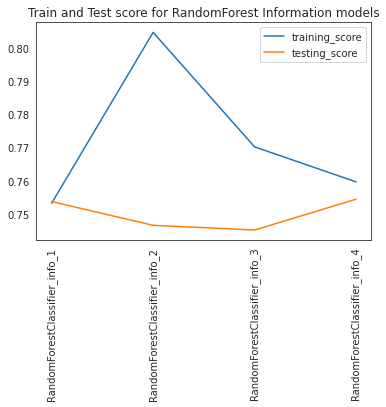

In [154]:
results.loc[['training_score',
             'testing_score'],
            ['RandomForestClassifier_info_1',
             'RandomForestClassifier_info_2',
             'RandomForestClassifier_info_3',
             'RandomForestClassifier_info_4']].transpose().plot.line()
plt.title('Train and Test score for RandomForest Information models')
plt.xticks(rotation='vertical')
plt.show()

Our attempts at making the info model any better are not successful. This may be due to overfitting and more samples may generate an improved model.

In [143]:
evaluate_performance('bogo', results).append([evaluate_performance('discount', results), evaluate_performance('info', results)]).transpose()


RandomForest
For bogo:

RandomForest
For discount:

RandomForest
For info:


,RandomForestClassifier_bogo_2,DecisionTreeClassifier_discount_1,RandomForestClassifier_discount_1,DecisionTreeClassifier_discount_2,DecisionTreeClassifier_discount_3,RandomForestClassifier_info_4
train_time,0.259924,0.021083,0.051943,0.022149,0.026735,0.339516
pred_time,0.050785,0.001231,0.011403,0.001254,0.001297,0.032537
training_score,0.853393,0.862855,0.862855,0.862855,0.862855,0.759714
testing_score,0.830350,0.872299,0.872299,0.872299,0.872299,0.754474


### Feature Importance

This is a factor that can show what feature(s) are the best indicator for a certain type of offer

##### Best Models
The 3 best models were BOGO-3, Discount-3 and Info-4... For the plots below however, we will use Info-2 because it was (almost) second-best though the differences between info-1,2,3 was insignificant. We'll use Info-2 because the parameters were trained.

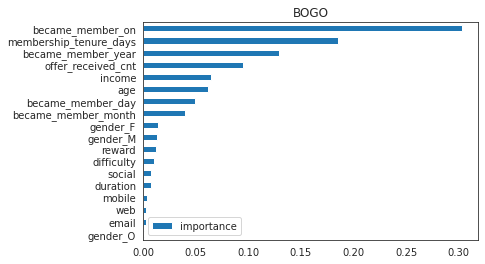

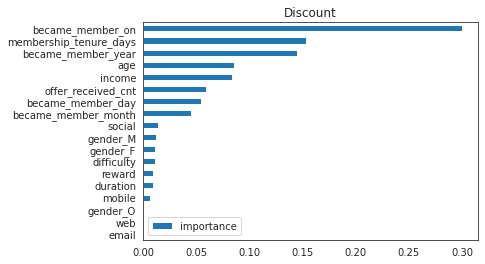

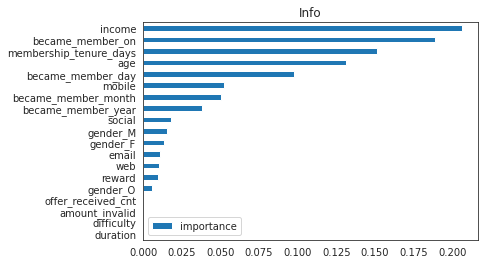

In [157]:
# show feature importance
# BOGO 3 model
# prepare data same as BOGO 3 state
drop_cols_prep = ['person','offer_id','effective_offer','offer_type','amount_invalid']
features,target = data_prep(offers_bogo,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_3.feature_importances_,
                                   index=features.columns,
                                   columns=['importance']).sort_values('importance')
feature_importances.plot.barh()
plt.title('BOGO')
plt.show()

# discount 3 model
feature_importances = pd.DataFrame(discount_3.feature_importances_,
                                   index=features.columns,
                                   columns=['importance']).sort_values('importance')
feature_importances.plot.barh()
plt.title('Discount')
plt.show()

# info_2 model
# prepare data similar to info_2 state
drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(offers_discount,drop_cols_prep)
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                   columns=['importance']).sort_values('importance')
feature_importances.plot.barh()
plt.title('Info')
plt.show()

### Type-3 and Type-4 analysis
These are folks who purchase regardless of the offer (3) and those who disregard the offer (4)

In [145]:
# Aggregate Datasets

# Type-3 and 4
response34 = type3_bogo.append(type3_discount, sort=False)
response34 = response34.append(type3_info, sort=False)
response34 = response34.append(type4_bogo, sort=False)
response34 = response34.append(type4_discount, sort=False)
response34 = response34.append(type4_info, sort=False)

## Aggregate Type-1 and Type-2 for plotting
# Type-1
response1_aggr = type1_bogo.append(type1_discount, sort=False)
response1_aggr = response1_aggr.append(type1_info, sort=False)

# Type-2
response2_aggr = type2_bogo.append(type2_discount, sort=False)
response2_aggr = response2_aggr.append(type2_info, sort=False)

# get unique person-offer_id pairs
response34 = response34[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
response1_aggr = response1_aggr[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
response2_aggr = response2_aggr[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

# get membership_tenure_days
response34 = membership_tenure(response34)
response1_aggr = membership_tenure(response1_aggr)
response2_aggr = membership_tenure(response2_aggr)

# merge with transcript to check transaction amount
response34 = response34.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),
                      on=['person','offer_id'],
                      how='left')
response1_aggr = response1_aggr.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),
                          on=['person','offer_id'],
                          how='left')
response2_aggr = response2_aggr.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),
                          on=['person','offer_id'],
                          how='left')

In [146]:
# check null values
print("For Type-3 and 4 Responses:")
print((response34.isnull().sum()/len(response34))*100)

#drop null values
response34 = response34.dropna()

#check null values
print("\n\nFor Type-1 Response:")
print((response1_aggr.isnull().sum()/len(response1_aggr))*100)

#drop null values
response1_aggr = response1_aggr.dropna()

#check null values
print("\n\nFor Type-2 Response:")
print((response2_aggr.isnull().sum()/len(response2_aggr))*100)

#drop null values
response2_aggr = response2_aggr.dropna()

For Type-3 and 4 Responses:
person                    0.000000
offer_id                  0.000000
gender                    9.019155
age                       9.019155
became_member_on          0.000000
income                    9.019155
became_member_day         0.000000
became_member_month       0.000000
became_member_year        0.000000
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64


For Type-1 Response:
person                    0.000000
offer_id                  0.000000
gender                    5.896762
age                       5.896762
became_member_on          0.000000
income                    5.896762
became_member_day         0.000000
became_member_month       0.000000
became_member_year        0.000000
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64


For Type-2 Response:
person                     0.000000
offer_id                   0.000000
gender                    21.131608
age               

In [147]:
print("Number of Type-1: "+ str(len(response1_aggr['person'])))
print("Number of Types-3 and 4: "+ str(len(response34['person'])))
print("Number of Type-2: "+ str(len(response2_aggr['person'])))

Number of Type-1: 26507
Number of Types-3 and 4: 18904
Number of Type-2: 5729


In [148]:
#create function for plotting multiple histograms overlaying the 3 groups
def plot_all_type_hist(variable, bins=None):
    '''
    Plot histograms for Type-1, Type-2 and Types-(3,4)
    Input:
    - variable: col in dataset to use for plot
    - bins: (optional) bins to pass to the plotting function

    Output:
    - None - draws the plots
    '''
    plt.hist(response1_aggr[variable], alpha=0.5, label='Type-1',bins=bins)
    plt.hist(response34[variable], alpha=0.5, label='Type-3 and 4',bins=bins)
    plt.hist(response2_aggr[variable], alpha=0.5, label='Type-2',bins=bins)
    plt.legend(loc='upper right')
    plt.title('distribution of ' + variable + ' between Type-1, Type-2 and Types 3 + 4')
    plt.show()

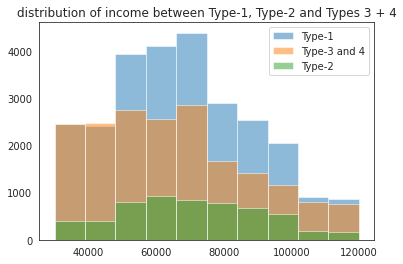

In [149]:
plot_all_type_hist('income')

Income distribution is relatively similar

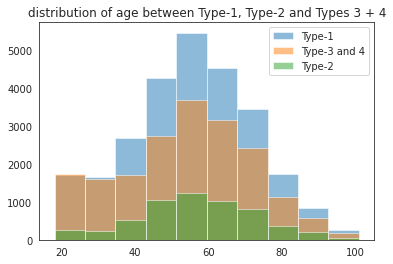

In [150]:
plot_all_type_hist('age')

Age plots look the same for all the groups

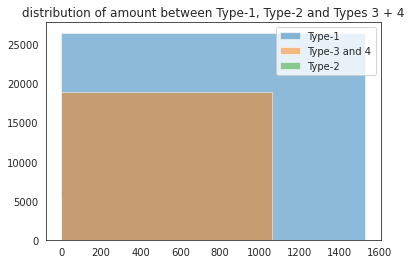

In [151]:
plot_all_type_hist('amount', bins=1)

Type-2 people are missing of course because the offers weren't successful for them


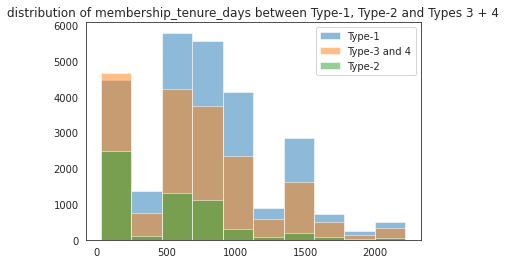

In [152]:
plot_all_type_hist('membership_tenure_days')

we can not draw any conclusions from this as the three plots look very similar.

# Conclusion

In this project we analyzed the dataset provided by starbucks and tried to see how certain advertisement campaigns can affect the purchasing decisions of consumers.

Starbucks targets consumers through 3 types of offers: BOGO, Discount and Informational

According to the details provided in the problem statement, we divided the consumers into 4 categories (type-1, type-2, type-3 and type-4)

Type-1 consumers are ideal: they complete the transactions after viewing the offer.

Type-2 consumers have viewed the offer but haven't completed it.

Type-3 consumers have completed the offer but may have seen the campaign advert later. 

Type-4 consumers have no action taken but they received the offer.

### Comments
This was a particularly challenging dataset. In the beginning I was not able to get the correct data in order for analysis. But luckily, there is a large corpus of help available from Udacity and I was able to take lead from various repositories and continue down my path for analysis of the data. Especially, the breaking of all data into 4 categories (types) was a novel idea that was not originally of my own thought.

## Exploration
The data exploration was most fun part of the process. It also is the most disjointed part of this notebook but I drew quite a few points of understanding from it.

Bar plots (especially clustered ones) were very useful in analysis of this type of data.

## Modeling
We compared different models for the offer types. For BOGO and Discount the model results were above 80% whereas for Information we didn't have very good results which could be because of lack of data. More data may provide a better model.

## Big Factors
Membership tenure is a huge factor in purchasing decisions of the customers. If someone decides to become a member, he is more likely to take up offers.

For the information campaigns, income also has a big influence on purchasing decisions.